Indexing is already done for the corpus. I take here the index path and trec6 topic file (50 queries). Then perform BM25 for k1 = 0.5 - 2.0 (with step_size = 0.1) and b = 0.1 - 0.9 (with step_size = 0.05). Plot the k1 vs MAP and b vs MAP. Choose k1,b correspodning to the highest MAP value. Use this optimal paramter values of BM25 as baseline for BM25 weighting in Rocchio.

In [7]:
topicFilePath = './trec6.xml'  # 50 queries

import xml.etree.ElementTree as ET

tree = ET.parse(topicFilePath)
topics = tree.getroot()

In [8]:
import lucene
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.analysis.en import EnglishAnalyzer
from java.io import File

In [9]:
lucene.initVM()

In [10]:
index_path = './index/'
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

### BM25 Retrieval

In [29]:
# setting up the searcher
analyzer = EnglishAnalyzer()    # used same analyzer as indexer
searcher = IndexSearcher(DirectoryReader.open(directory))

queries = []
for topic in topics:
    qidField = 'num'
    queryKeywordsField = 'title'     # other fields are 'desc'and 'narr'

    qid = topic.find(qidField).text.strip()
    q = topic.find(queryKeywordsField).text.strip()

    escaped_q = QueryParser('CONTENT', analyzer).escape(q)      # a few titles had '/' in them which 
                                                                # EnglishAnalyzer was not able to parse
                                                                # without escaping those special characters
    query = QueryParser('CONTENT', analyzer).parse(escaped_q)
    queries.append(query)


def bm25(k1,b):
    model = 'bm25'
    similarityModel = BM25Similarity(k1,b)
    # setting the similarity model
    searcher.setSimilarity(similarityModel)

    # change result file path below
    outputPath = f'./Baseline BM25/BM25_{k1}-{b}.res'
    f = open(outputPath, 'w')

    print('\nRetrieving ...')

    # search on 50 queries from the topic file 'trec6.xml'
    qid = 300
    for query in queries:
        qid += 1
        print(f'BM25, k1 = {k1}, b = {b}; qid = {qid}, retrieving & writing ...', end=' ')

        # getting the top k search results using the searcher
        k = 1000
        scoreDocs = searcher.search(query, k).scoreDocs

        # writing all k doc results in a .res file in trec format
        rank = 0
        for scoreDoc in scoreDocs:
            rank += 1
            doc = searcher.doc(scoreDoc.doc)
            # print(qid,'Q0', doc.get('DOCID'), rank, scoreDoc.score, f'aman_{method}_{LAMBDA}')
            f.write(f"{qid}\tQ0\t{doc.get('DOCID')}\t{rank}\t{scoreDoc.score}\taman_{model}_{k1}-{b}\n")

        print('complete!')

    f.close()
    print('Search completed! Search results exported to a .res file in the current directory.\n')

In [ ]:
k1_range = [i/10 for i in range(5,21)]      # k1 = 0.5, 0.6,..., 2.0
b_range = [i/20 for i in range(2,19)]       # b = 0.1, 0.15,..., 0.9

for k1 in k1_range:
    for b in b_range:
        bm25(k1,b)

### trec_eval the results and writing MAPs for params

In [32]:
import subprocess
import csv

In [33]:
def bm25_MAPs():
    f = open('./Baseline BM25/BM25_params_vs_MAP.tsv', 'w')
    tsv_writer = csv.writer(f, delimiter='\t')
    tsv_writer.writerow(['method','k1','b','MAP'])
    
    MAPs = []

    print(f'trec_eval, BM25; evaluating & writing ...', end=' ')
    for k1 in k1_range:
        for b in b_range:
            bm25OutputPath = f'./Baseline BM25/BM25_{k1}-{b}.res'
            result = subprocess.run(['trec_eval', 'trec678_robust.qrel', bm25OutputPath], stdout=subprocess.PIPE)
            shell_output_string = result.stdout.decode('utf-8')
            if shell_output_string.split()[15] == 'map':
                map_value = float(shell_output_string.split()[17])
                MAPs.append([k1,b,map_value])
                tsv_writer.writerow(['bm25', k1, b, map_value])
            else:
                raise Exception('map_value index misalignment')
    print('done!')
    
    f.close()
    return MAPs

In [34]:
MAPs = bm25_MAPs()

trec_eval, BM25; evaluating & writing ... done!


In [58]:
# highest MAP value and corresponding k1,b

res = max(MAPs, key=lambda x:x[2])
print(res)
print(f'max MAP = {res[2]}, for k1 = {res[0]} and b = {res[1]}')

[0.8, 0.4, 0.2488]
max MAP = 0.2488, for k1 = 0.8 and b = 0.4


In [36]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

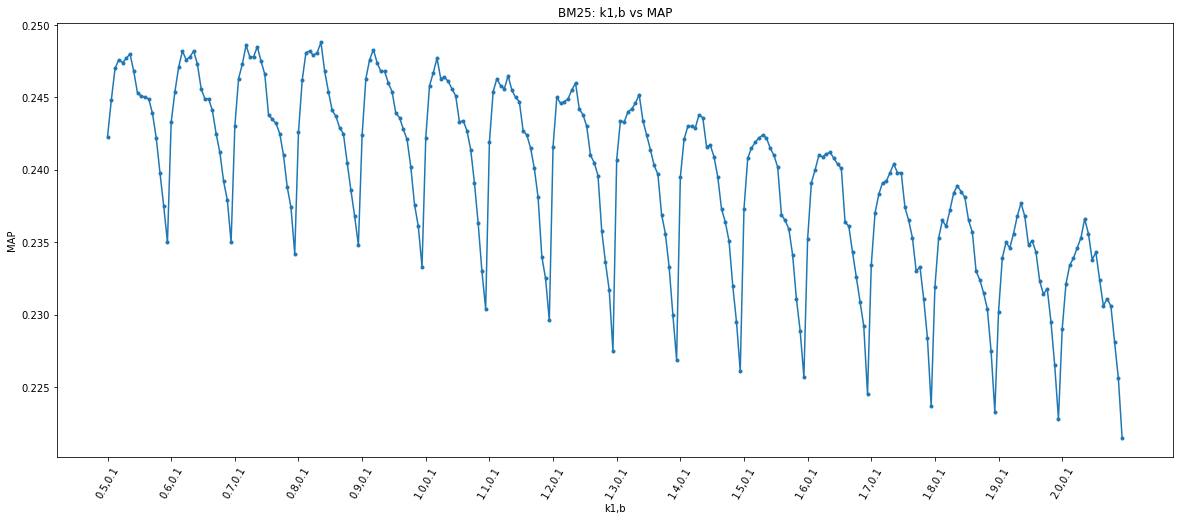

In [56]:
fig, ax = plt.subplots()

fig.set_figwidth(20)
fig.set_figheight(8)

X = range(len(MAPs))
Y = [ele[2] for ele in MAPs]

plt.plot(X,Y, '.-')

kb = [f'{ele[0]},{ele[1]}' for ele in MAPs]
ax.set_xticks(X[::17], labels=[kb[i] for i in X[::17]])
plt.xticks(rotation=60)

plt.title('BM25: k1,b vs MAP')
plt.xlabel('k1,b')
plt.ylabel('MAP')
plt.savefig('./Baseline BM25/BM25 k1,b vs MAP plot.png', facecolor='white', transparent=False, dpi=300)
plt.show()